In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv("hand_landmarks_data.csv")

In [3]:
data = df.drop("label", axis=1)
labels = df["label"]

# Standard Scaler

In [4]:
standard_scaled_data = StandardScaler().fit_transform(data)

In [5]:
standard_scaled_data = pd.DataFrame(standard_scaled_data, columns= data.columns)
# standard_scaled_data['label'] = labels
standard_scaled_data

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
0,0.670854,-0.037287,-1.797620,0.647642,-0.066411,1.319333,0.547440,0.014332,1.556203,0.418844,...,0.698066,0.229175,0.363009,0.650346,0.141274,0.386439,0.365511,0.065547,0.397707,0.099620
1,-1.310594,1.122418,-1.321361,-1.422595,1.014112,-0.157838,-1.402588,0.948726,-0.368595,-1.348258,...,-0.313795,-0.737317,1.480503,-0.216310,-0.630322,1.466434,-0.245644,-0.528548,1.440795,-0.345760
2,-0.156927,0.001006,-1.347674,-0.083247,-0.140738,0.894515,0.054676,-0.227135,0.447953,0.155543,...,-1.093810,0.515804,0.532792,-0.504453,0.647150,0.554235,-0.395721,0.760222,0.556077,-0.448179
3,-0.961142,0.933413,-0.915206,-1.038276,0.907823,0.640059,-1.072327,0.929264,0.503462,-1.071493,...,0.148480,-0.601809,1.319466,0.299668,-0.541924,1.299211,0.208121,-0.490506,1.272376,0.052268
4,-0.145454,-1.547472,-1.057555,-0.165113,-1.647155,0.634264,-0.135307,-1.734938,0.560447,-0.131491,...,0.160026,0.264811,-1.232587,0.422349,0.352546,-1.238128,0.388980,0.424532,-1.242218,0.252739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25670,0.631800,0.227144,1.114438,0.809029,0.069220,1.599665,0.826848,-0.041590,1.461887,0.681882,...,-0.613276,0.311658,0.036939,0.239085,0.354527,0.092131,0.732754,0.381996,0.163967,1.047063
25671,-1.236424,-0.051963,0.926299,-1.477129,-0.189514,1.276409,-1.544625,-0.269997,1.032529,-1.426952,...,-1.185513,-0.904890,-0.213954,-0.485977,-0.951598,-0.159718,0.129223,-0.980237,-0.080900,0.624434
25672,0.384160,-0.113179,1.694753,0.618160,-0.261933,1.042752,0.660853,-0.410555,1.021421,0.553074,...,-0.567921,0.107836,-0.324559,0.098301,0.146079,-0.240303,0.490399,0.172995,-0.157204,0.852797
25673,-0.911525,0.649195,1.112943,-1.070498,0.519943,1.507268,-1.069108,0.442154,1.276755,-0.926417,...,-1.314118,-0.473976,0.564564,-0.613420,-0.502133,0.630530,-0.028352,-0.553291,0.677870,0.404578


In [6]:
X_standard_scaled_train, X_standard_scaled_test, y_train, y_test = train_test_split(standard_scaled_data, labels, test_size=.2, random_state=42)

# Custom Scaler

In [7]:
def normalize_landmarks(row):
    # reshape data to make each landmark x,y,z in one row
    landmarks = row.values.reshape(-1,3)
    # wirst landmark
    wirst = landmarks[0]
    
    # middle finger landmark
    tip_point = landmarks[12]

    # the distance between wirst landmark and middle finger landmark
    scale = np.linalg.norm(wirst - tip_point)

    # normalizing each gesture "data observation" as we have global or absolute coordinates with respect to camera position
    # so we need to make it relative to handel different hand scales and positions
    # we consider the distance between wirst landmark and middle finger landmark as standard deviation
    # we consider wirst as mean
    landmarks = (landmarks - wirst) / scale + 1e-6

    # retuen flatten normalized landmarks
    return landmarks.flatten()


In [8]:
custom_normalized_data = data.apply(normalize_landmarks, axis=1, result_type="expand")
custom_normalized_data.columns = data.columns
# custom_normalized_data['label'] = labels

In [9]:
X_custom_scaled_train, X_custom_scaled_test, y_train, y_test = train_test_split(custom_normalized_data, labels, test_size=.2, random_state=42)

In [10]:
# normalized data after removing the wirst point
# custom_normalized_data = custom_normalized_data.drop(["x1","y1","z1"], axis=1)

# Modelling

## On Standard Scaled Data

In [11]:
lb = LabelEncoder()
encoded_label = lb.fit_transform(y_train)

In [12]:
xgb_ss = XGBClassifier()
xgb_ss.fit(X_standard_scaled_train, encoded_label)
xgb_pred_ss = xgb_ss.predict(X_standard_scaled_test)

In [13]:
print(classification_report(y_test, lb.inverse_transform(xgb_pred_ss)))

                 precision    recall  f1-score   support

           call       0.97      0.94      0.96       287
        dislike       1.00      0.98      0.99       260
           fist       0.97      0.98      0.98       209
           four       0.87      0.94      0.90       325
           like       0.96      0.97      0.97       304
           mute       0.96      0.92      0.94       195
             ok       0.99      0.99      0.99       340
            one       0.94      0.93      0.93       248
           palm       0.89      0.88      0.89       317
          peace       0.79      0.85      0.82       276
 peace_inverted       0.92      0.85      0.88       307
           rock       0.97      0.97      0.97       290
           stop       0.87      0.90      0.89       293
  stop_inverted       0.96      0.96      0.96       309
          three       0.99      0.93      0.96       298
         three2       0.95      0.93      0.94       331
         two_up       0.85    

## On Custom Scaled Data

In [14]:
xgb_cs = XGBClassifier()
xgb_cs.fit(X_custom_scaled_train, encoded_label)
xgb_pred_cs = xgb_cs.predict(X_custom_scaled_test)

In [15]:
print(classification_report(y_test, lb.inverse_transform(xgb_pred_cs)))

                 precision    recall  f1-score   support

           call       1.00      0.99      0.99       287
        dislike       1.00      1.00      1.00       260
           fist       0.99      0.99      0.99       209
           four       0.96      0.98      0.97       325
           like       1.00      0.99      1.00       304
           mute       0.94      0.97      0.95       195
             ok       0.99      0.99      0.99       340
            one       0.97      0.94      0.95       248
           palm       0.98      0.98      0.98       317
          peace       0.97      0.99      0.98       276
 peace_inverted       0.98      0.97      0.98       307
           rock       0.99      0.99      0.99       290
           stop       0.96      0.98      0.97       293
  stop_inverted       0.99      0.96      0.98       309
          three       0.99      0.96      0.97       298
         three2       0.99      1.00      1.00       331
         two_up       0.98    

# Performance Analysis

## Confusion Matrix

In [16]:
def plot_confusion_matrix(model, pred):
    classes = lb.inverse_transform(model.classes_)
    cm = confusion_matrix(y_test, lb.inverse_transform(pred))
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True,fmt='')
    plt.show()

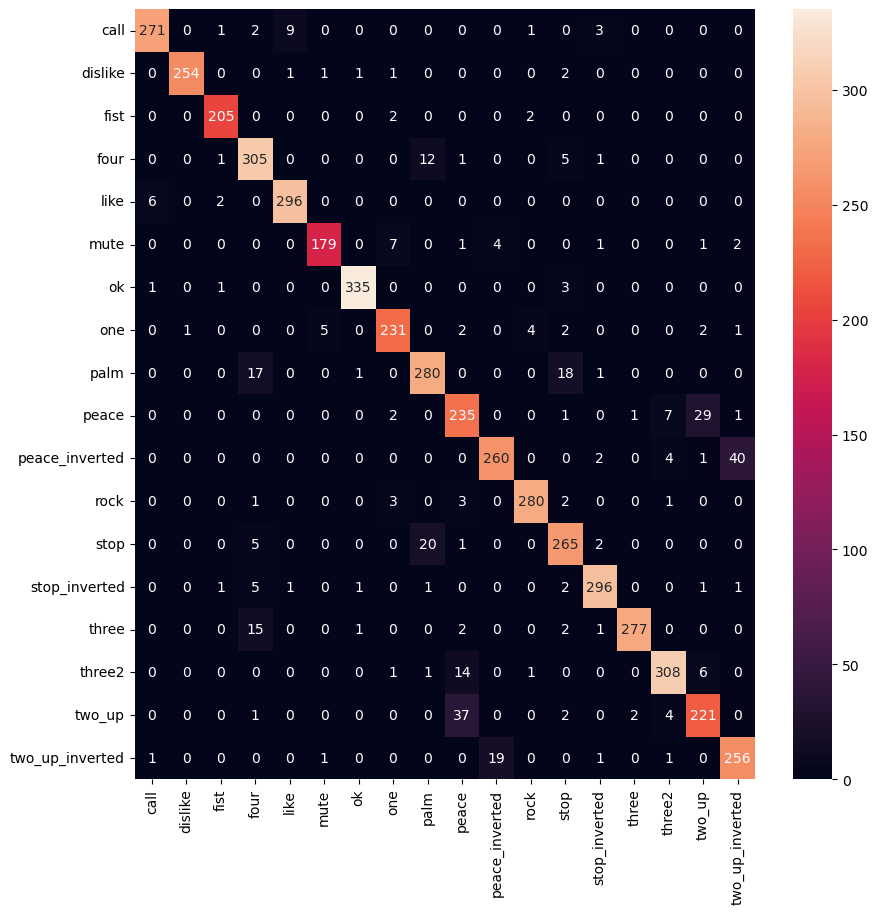

In [17]:
# For model trained on standard scaled data
plot_confusion_matrix(xgb_ss,xgb_pred_ss)

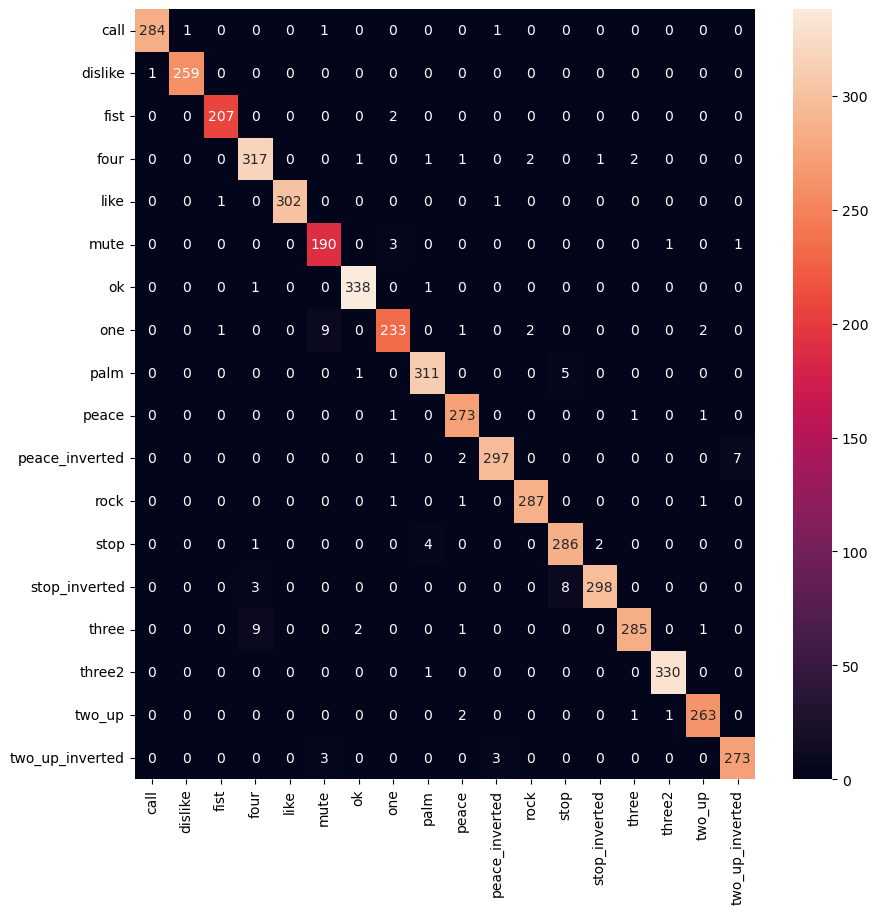

In [18]:
# For model trained on custom scaled data
plot_confusion_matrix(xgb_cs,xgb_pred_cs)

By inspecting the first confusion matrix we can observe that there are confusions between two_up and peace and its invertes.

And in the second confusion matrix these confusions becoming less.

# Landmarks Distribution
## For Standard Scaled

In [19]:
# Concatenate label feature again to do our analysis.
custom_normalized_data['label'] = labels
standard_scaled_data['label'] = labels

In [20]:
def plot_sample(vis_sample):
    
    for i in range(len(vis_sample)):
        row = vis_sample.iloc[i]
        xs = row[[f"x{i}" for i in range(1,22)]]
        ys = row[[f"y{i}" for i in range(1,22)]]
        
        plt.scatter(x=xs, y=ys)


        plt.title(row["label"])
        plt.axis("equal")
        plt.gca().invert_yaxis()
        plt.show()

In [ ]:
# Focus on only the two classes
classes_to_compare = ['two_up_inverted', 'peace_inverted']
df_filtered = standard_scaled_data[standard_scaled_data['label'].isin(classes_to_compare)]

# Get x and y feature columns only
xy_columns = [col for col in standard_scaled_data.columns if ('x' in col or 'y' in col) and 'label' not in col]

# Melt the data for seaborn plotting
melted_df = df_filtered.melt(id_vars='label', value_vars=xy_columns, 
                              var_name='feature', value_name='value')

# Subplot settings
num_features = len(xy_columns)
cols = 4
rows = -(-num_features // cols)  # Ceiling division

plt.figure(figsize=(20, rows * 4))

for i, feature in enumerate(xy_columns):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(data=melted_df[melted_df['feature'] == feature],
                x='label', y='value', palette="Set2")
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('')

plt.suptitle("Boxplots of X and Y Features for 'two_up_inverted' vs 'peace_inverted'", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


By inspecting distributions of all features we can note that all fateures almost have the same mean and Inter Quantile Range -IQR- which make dicrimination between the two signs difficult and this is the reason of confusion.

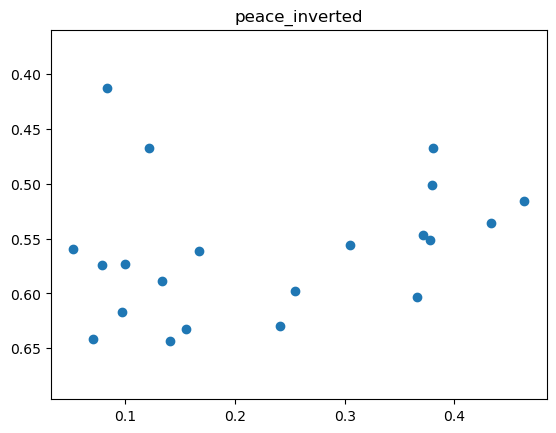

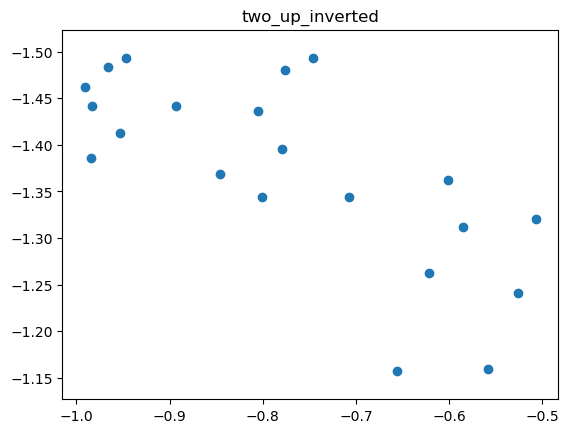

In [22]:
plot_sample(df_filtered.groupby('label').sample(n=1, random_state=42))

As we see, the sign's landmarks struture is distorted because we use the standard scaling. 

## For Custom Scaled

In [ ]:
# Focus on only the two classes
classes_to_compare = ['two_up_inverted', 'peace_inverted']
df_filtered = custom_normalized_data[custom_normalized_data['label'].isin(classes_to_compare)]

# Get x and y feature columns only
xy_columns = [col for col in custom_normalized_data.columns if ('x' in col or 'y' in col) and 'label' not in col]

# Melt the data for seaborn plotting
melted_df = df_filtered.melt(id_vars='label', value_vars=xy_columns, 
                              var_name='feature', value_name='value')

# Subplot settings
num_features = len(xy_columns)
cols = 4
rows = -(-num_features // cols)  # Ceiling division

plt.figure(figsize=(20, rows * 4))

for i, feature in enumerate(xy_columns):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(data=melted_df[melted_df['feature'] == feature],
                x='label', y='value', palette="Set2")
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('')

plt.suptitle("Boxplots of X and Y Features for 'two_up_inverted' vs 'peace_inverted'", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


By inspect "y13" distributions, we can see that there is no intersection between the IQR of the two distributions.

So, based on it, we can decide if the sample belongs to neither two_up_inverted nor peace_inverted.

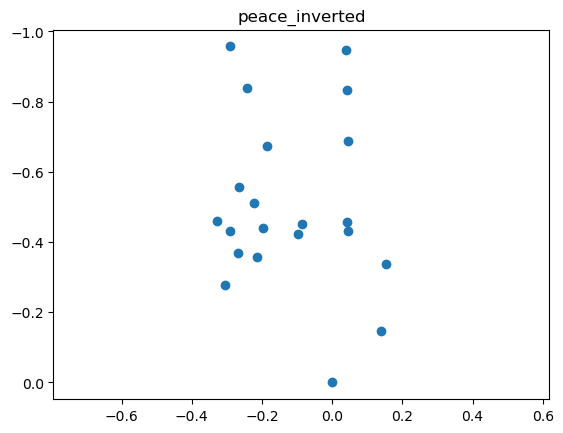

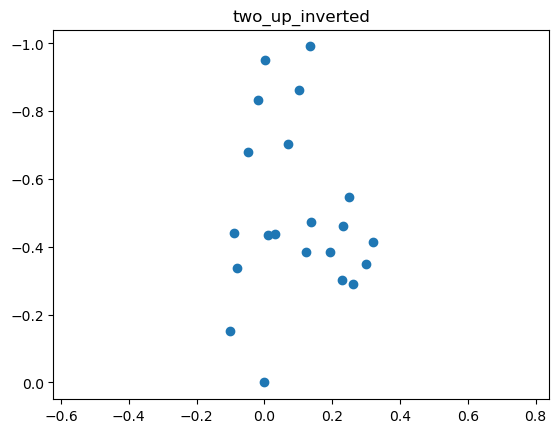

In [24]:
# df_filtered.groupby('label').sample(n=1)#.drop('label',axis=1)[xy_columns]
plot_sample(df_filtered.groupby('label').sample(n=1, random_state=42))

Here the custom normalization keeps the strcuture of sings.

# Feature Impotance

In [25]:
binary_dt = DecisionTreeClassifier()

In [26]:
data_fi = df_filtered.drop("label", axis=1)
label_fi = df_filtered['label']

In [27]:
xtr,xtst,ytr,ytst = train_test_split(data_fi,label_fi,shuffle=True)

In [28]:
binary_dt.fit(xtr,ytr)

DecisionTreeClassifier()

In [29]:
sorted_featrues = [df.columns[i] for i in np.argsort(binary_dt.feature_importances_ )[::-1]]
print("the most important -discriminative- feature:", sorted_featrues[0])

the most important -discriminative- feature: y13


**Which meet our analysis <3**

# *Thank you for reading this notebook*